In [1]:
sys.path.insert(0, './common')

import numpy as np
from collections import deque
import sys
import cartpole
import a2c_model

In [2]:
env = cartpole.CartPoleEnv()

CARTPOLE environment created.


In [3]:
model = a2c_model.A2C(4, 2, 100, lr=5e-4)
save_path = './models/a2c-cartpole.pth'
model.set_model_save_path(save_path)

In [4]:
model.train(env, 500, show_plot=False)

EPOCH: 0, total reward: 16.0, timestep: 16
EPOCH: 1, total reward: 34.0, timestep: 34
EPOCH: 2, total reward: 20.0, timestep: 20
EPOCH: 3, total reward: 34.0, timestep: 34
EPOCH: 4, total reward: 14.0, timestep: 14
EPOCH: 5, total reward: 17.0, timestep: 17
EPOCH: 6, total reward: 16.0, timestep: 16
EPOCH: 7, total reward: 31.0, timestep: 31
EPOCH: 8, total reward: 35.0, timestep: 35
EPOCH: 9, total reward: 9.0, timestep: 9
EPOCH: 10, total reward: 16.0, timestep: 16
EPOCH: 11, total reward: 24.0, timestep: 24
EPOCH: 12, total reward: 10.0, timestep: 10
EPOCH: 13, total reward: 26.0, timestep: 26
EPOCH: 14, total reward: 30.0, timestep: 30
EPOCH: 15, total reward: 29.0, timestep: 29
EPOCH: 16, total reward: 29.0, timestep: 29
EPOCH: 17, total reward: 17.0, timestep: 17
EPOCH: 18, total reward: 18.0, timestep: 18
EPOCH: 19, total reward: 15.0, timestep: 15
EPOCH: 20, total reward: 18.0, timestep: 18
EPOCH: 21, total reward: 25.0, timestep: 25
EPOCH: 22, total reward: 21.0, timestep: 21


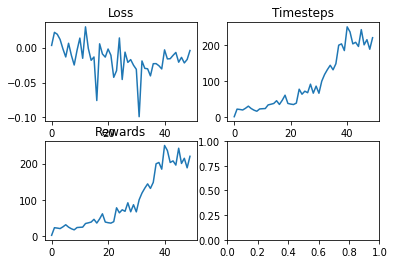

In [5]:
model.plot_train_memory()

In [6]:
env = cartpole.CartPoleEnv()
model.test(env)

CARTPOLE environment created.


(500.0, 500)